In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("old_dataset.csv")
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [2]:
from sklearn.feature_selection import chi2

df = df.dropna()

xs = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status']]
ys = df['stroke']

In [3]:
df['smoking_status'].value_counts()

# group children with never worked ?
# smoking_type -> ordinal coding 
#   0 unknown
#   1 never smoked
#   2 formerly smoke 
#   3 smokes
# + other variable for unknown or not

never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64

In [4]:
from sklearn.preprocessing import OneHotEncoder

s = (xs.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(xs[object_cols]))

# One-hot encoding removed index; put it back
OH_cols.index = xs.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = xs.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X = pd.concat([num_X, OH_cols], axis=1)

Categorical variables:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [5]:
fnames = OH_encoder.get_feature_names_out()
fnames

array(['gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'], dtype=object)

In [6]:
chi2stats, pvals = chi2(OH_X, ys)

In [7]:
cont_features = np.array(["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"])
cols = np.concatenate((cont_features, fnames))
d = np.array([chi2stats])
results = pd.Series(data=chi2stats, index=cols).sort_values(ascending=False)
results

age                               3144.139535
avg_glucose_level                 1775.520314
hypertension                        90.543821
heart_disease                       88.779204
ever_married_No                     35.384105
work_type_children                  27.785710
smoking_status_Unknown              19.279252
ever_married_Yes                    18.829557
bmi                                 18.814363
smoking_status_formerly smoked      13.378757
work_type_Self-employed             12.667614
smoking_status_smokes                1.933969
work_type_Never_worked               0.978298
work_type_Private                    0.467894
smoking_status_never smoked          0.351515
gender_Male                          0.139529
gender_Female                        0.094433
Residence_type_Rural                 0.090581
Residence_type_Urban                 0.087999
work_type_Govt_job                   0.054022
gender_Other                         0.044468
dtype: float64

In [8]:
for featname in object_cols:
    matchcols = fnames[np.char.startswith(fnames.astype('str'), featname)]
    results[featname] = results[matchcols].sum()
    results = results.drop(matchcols)

results = results.sort_values(ascending=False)
results

age                  3144.139535
avg_glucose_level    1775.520314
hypertension           90.543821
heart_disease          88.779204
ever_married           54.213662
work_type              41.953538
smoking_status         34.943492
bmi                    18.814363
gender                  0.278430
Residence_type          0.178580
dtype: float64

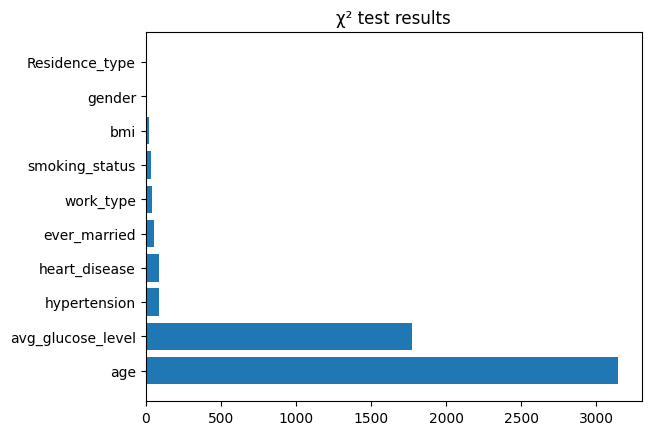

In [9]:
import matplotlib.pyplot as plt

plt.barh(results.index, results.values)
plt.title("χ² test results")
plt.show()

In [10]:
from sklearn.feature_selection import f_classif

f_stats, p_vals = f_classif(OH_X, ys)

In [11]:
results = pd.Series(data=f_stats, index=cols).sort_values(ascending=False)
results

age                               279.980918
hypertension                      101.729361
avg_glucose_level                  96.585072
heart_disease                      95.175560
ever_married_No                    54.796734
ever_married_Yes                   54.796734
work_type_children                 32.384214
smoking_status_Unknown             27.769605
smoking_status_formerly smoked     16.175335
work_type_Self-employed            15.082497
bmi                                 8.826500
smoking_status_smokes               2.275740
work_type_Private                   1.094600
work_type_Never_worked              0.982498
smoking_status_never smoked         0.564306
gender_Male                         0.236267
gender_Female                       0.230321
Residence_type_Rural                0.178514
Residence_type_Urban                0.178514
work_type_Govt_job                  0.061951
gender_Other                        0.044459
dtype: float64

In [12]:
for featname in object_cols:
    matchcols = fnames[np.char.startswith(fnames.astype('str'), featname)]
    results[featname] = results[matchcols].sum()
    results = results.drop(matchcols)

results = results.sort_values(ascending=False)
results

age                  279.980918
ever_married         109.593469
hypertension         101.729361
avg_glucose_level     96.585072
heart_disease         95.175560
work_type             49.605759
smoking_status        46.784986
bmi                    8.826500
gender                 0.511047
Residence_type         0.357028
dtype: float64

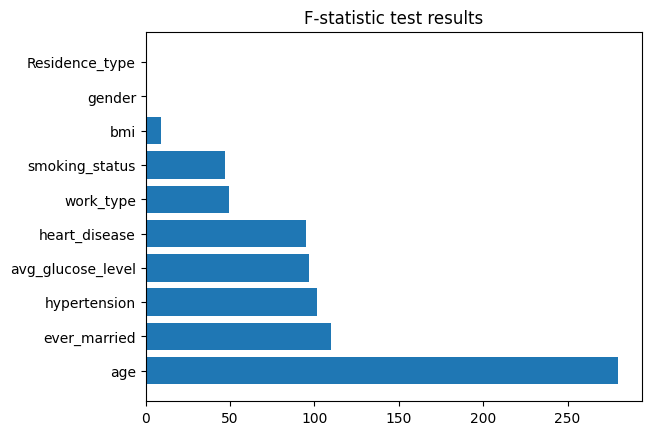

In [13]:
plt.barh(results.index, results.values)
plt.title("F-statistic test results")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(OH_X, ys)

RandomForestClassifier()

In [15]:
results = pd.Series(data=model.feature_importances_, index=cols).sort_values(ascending=False)
results

avg_glucose_level                 2.704286e-01
age                               2.362568e-01
bmi                               2.310329e-01
hypertension                      2.828713e-02
heart_disease                     2.614347e-02
work_type_Private                 2.010079e-02
smoking_status_never smoked       1.976152e-02
gender_Male                       1.842219e-02
Residence_type_Rural              1.827918e-02
Residence_type_Urban              1.763147e-02
work_type_Self-employed           1.732049e-02
smoking_status_formerly smoked    1.715226e-02
smoking_status_smokes             1.685364e-02
gender_Female                     1.667144e-02
work_type_Govt_job                1.412925e-02
smoking_status_Unknown            1.306780e-02
ever_married_No                   1.002605e-02
ever_married_Yes                  7.730188e-03
work_type_children                6.949609e-04
work_type_Never_worked            9.830877e-06
gender_Other                      3.357333e-08
dtype: float6

In [16]:
for featname in object_cols:
    matchcols = fnames[np.char.startswith(fnames.astype('str'), featname)]
    results[featname] = results[matchcols].sum()
    results = results.drop(matchcols)

results = results.sort_values(ascending=False)

In [17]:
results

avg_glucose_level    0.270429
age                  0.236257
bmi                  0.231033
smoking_status       0.066835
work_type            0.052255
Residence_type       0.035911
gender               0.035094
hypertension         0.028287
heart_disease        0.026143
ever_married         0.017756
dtype: float64

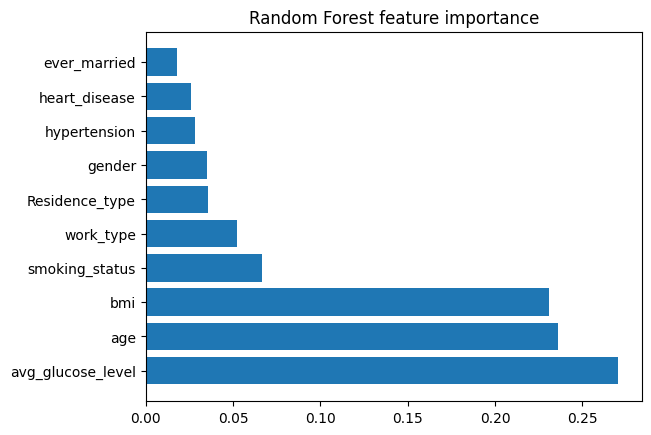

In [18]:
plt.barh(results.index, results.values)
plt.title("Random Forest feature importance")
plt.show()

In [20]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, OH_X, ys, n_repeats=30)


KeyboardInterrupt: 

In [ ]:
results = pd.Series(data=r.importances_mean, index=cols).sort_values(ascending=False)
results

In [ ]:
for featname in object_cols:
    matchcols = fnames[np.char.startswith(fnames.astype('str'), featname)]
    results[featname] = results[matchcols].sum()
    results = results.drop(matchcols)

results = results.sort_values(ascending=False)
results

In [ ]:
plt.barh(results.index, results.values)
plt.title("Permutation feature importance")
plt.show()

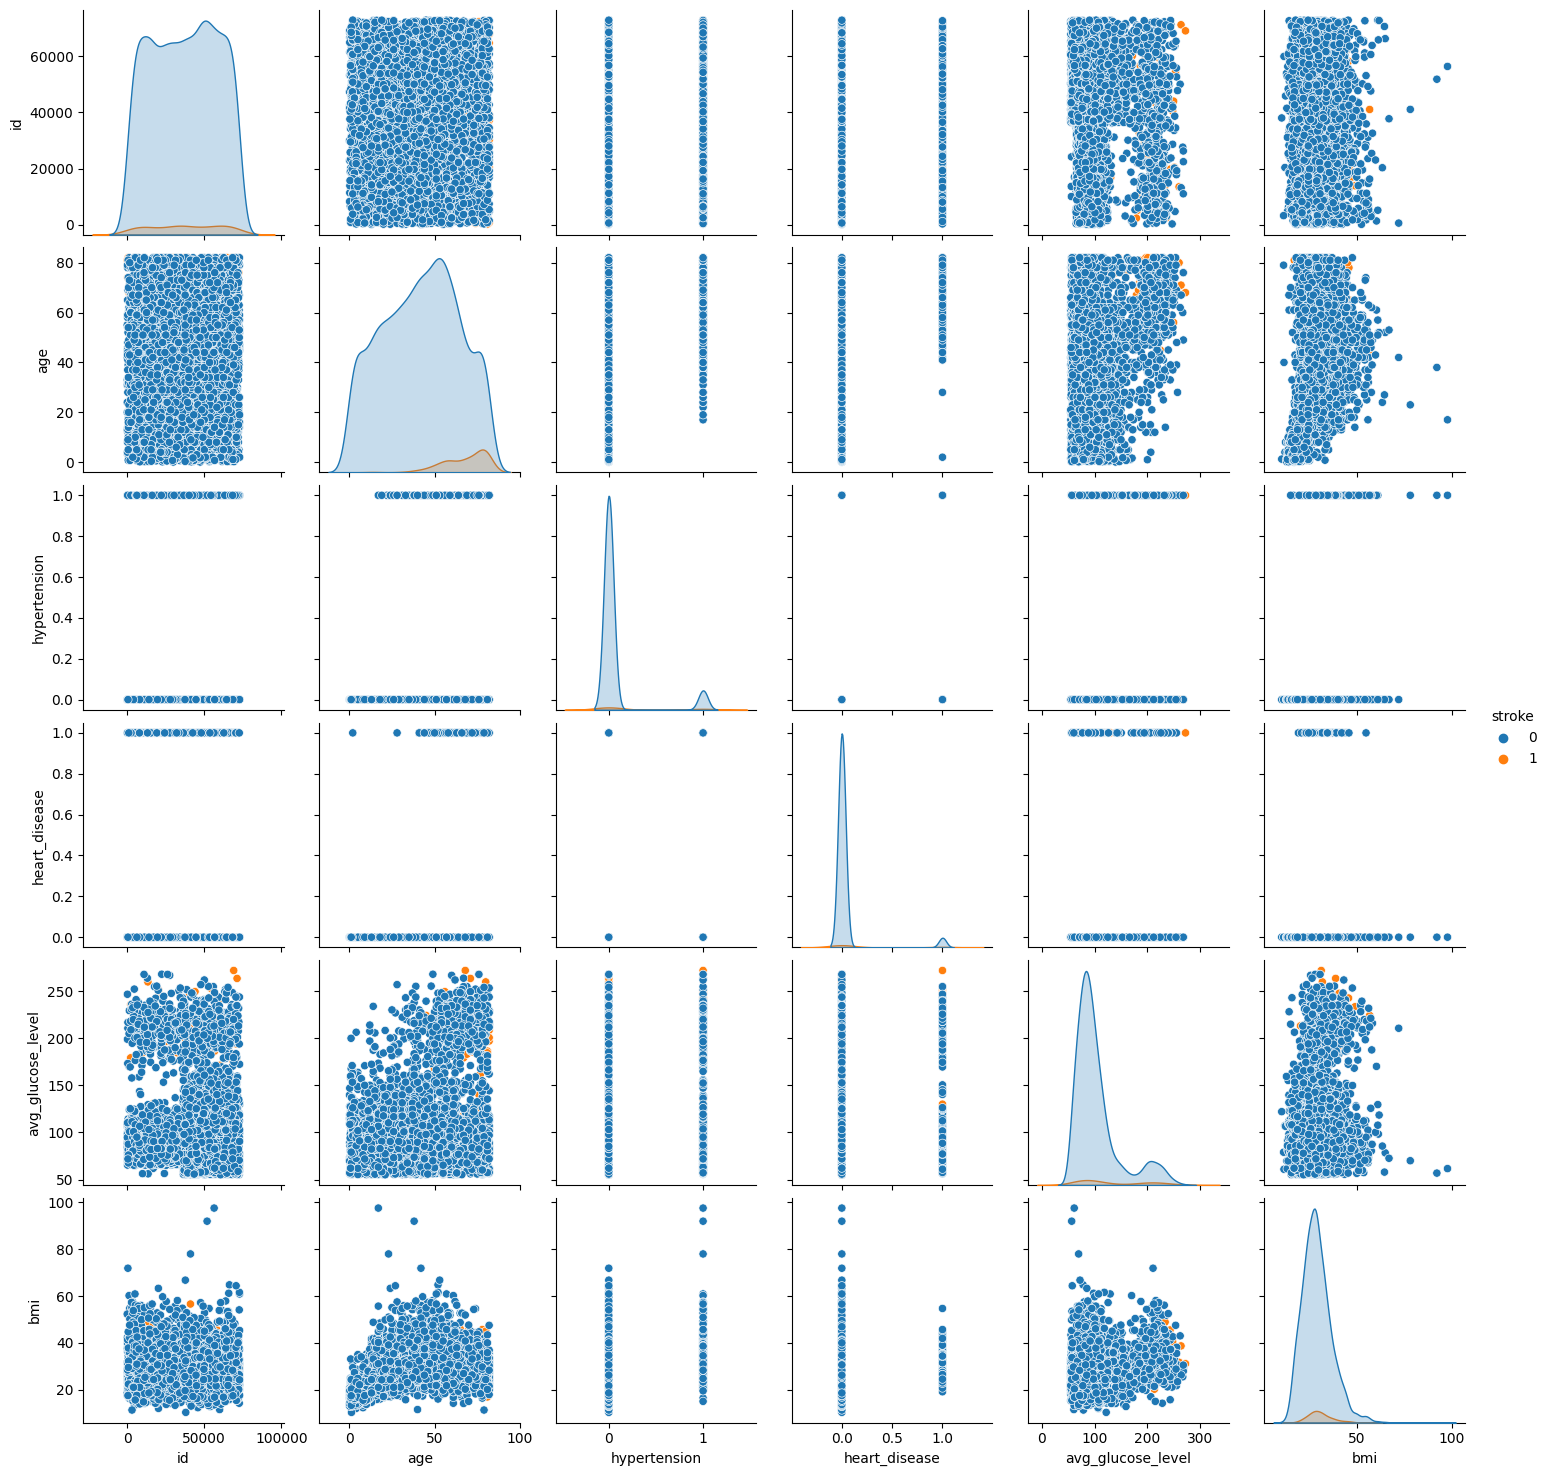

In [26]:
import seaborn
seaborn.pairplot(df, hue="stroke")

In [ ]:
df